# Ground Truth

## Overview
In this Jupyter Notebook we inspect the ground truth data, generate the target raster for training and compare Sentinel-2 Level-1C data with Level-2A data.

## How To Run
Please refer to the README file in this repository for a tutorial on how to set up GEE. Additionally you need a "../data/interim/plot.csv" file with columns:
```python
"conifer": 0 <= int <= 1  # Conifer proportion computed by base area
"date": str  # Date in YYYY-MM-DD format
"dbh": 0 < float  # DBH in meters
"latitude": float
"longitude": float
```
Then you can run the notebook using **Run All** in your IDE.

# Target Preprocessing
The target raster is computed from the [25 ha Traunstein Forest Dynamics Plot](https://forestgeo.si.edu/sites/europe/traunstein). You can request the dataset [here](http://ctfs.si.edu/datarequest/index.php/request/form/31). Alternatively you can use the processed GeoTIFF raster "data/processed/target.tif" for the leaf type mixture label. The raster "data/processed/target_area.tif" contains the base area per leaf type.

We load the plot data and visualize it:

In [1]:
# Load the data and convert it to a GeoDataFrame
import pandas as pd
import geopandas as gpd

df = pd.read_csv("../data/interim/plot.csv", parse_dates=["date"])

data = df.drop(["longitude", "latitude"], axis=1)
geometry = gpd.points_from_xy(df["longitude"], df["latitude"])
gdf = gpd.GeoDataFrame(data, crs="EPSG:4326", geometry=geometry)

gdf = gdf.to_crs("EPSG:32633")

print("Data types per column:\n")
print(gdf.dtypes)

Data types per column:

conifer              int64
date        datetime64[ns]
dbh                float64
geometry          geometry
dtype: object


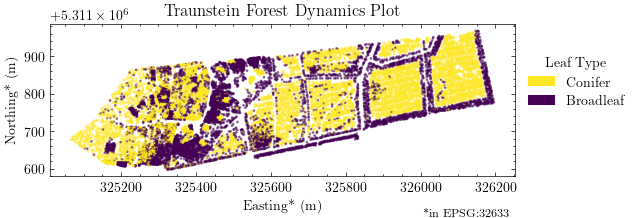

In [2]:
# Plot the data on stem level
from matplotlib.patches import Patch
from matplotlib.cm import viridis
from pathlib import Path
import matplotlib.pyplot as plt
import scienceplots

plt.style.use("science")

# Plot
ax = gdf.plot(
    markersize=1, figsize=(6, 2), alpha=0.5, column="conifer", cmap=viridis
)
legend_elements = [
    Patch(facecolor=viridis.get_over(), label="Conifer"),
    Patch(facecolor=viridis.get_under(), label="Broadleaf"),
]
golden_ratio = (1 + 5**0.5) / 2
ax.legend(
    handles=legend_elements,
    title="Leaf Type",
    loc="center left",
    bbox_to_anchor=(1, 1 / golden_ratio),
)

# Format
ax.set_title("Traunstein Forest Dynamics Plot")
ax.set_xlabel("Easting* (m)")
ax.set_ylabel("Northing* (m)")
ax.annotate(
    "*in EPSG:32633",
    (ax.get_position().x1 - 0.05, 0),
    xycoords="figure fraction",
    va="bottom",
    ha="right",
    fontsize="small",
)

figure_path = f"../reports/figures/ground_truth/{ax.get_title()}.svg"
Path(figure_path).parent.mkdir(parents=True, exist_ok=True)
plt.savefig(figure_path, dpi=300, transparent=True)

First sample: 2015-03-11
Last sample: 2016-04-13


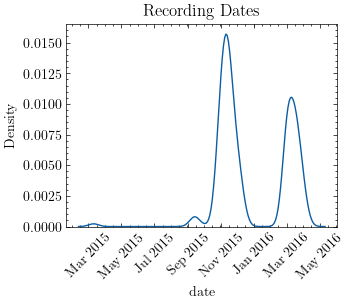

In [3]:
# Plot the distribution of the recording dates
import seaborn as sns
import matplotlib.dates as mdates

print(f"First sample: {gdf['date'].min().strftime('%Y-%m-%d')}")
print(f"Last sample: {gdf['date'].max().strftime('%Y-%m-%d')}")

ax = sns.kdeplot(gdf["date"], label="Recording Dates KDE")
ax.set_title("Recording Dates")
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))

figure_path = f"../reports/figures/ground_truth/{ax.get_title()}.svg"
plt.savefig(figure_path, dpi=300)

The recording dates of the plot range from March 11, 2015 to April 13, 2016. We will keep this date range in mind for determining the Level of Sentinel-2 data to use later in the notebook.

The plot data is converted to a raster with a resolution of 10 meters and the appropriate UTM coordinate reference system projection as the Sentinel-2 data. See [Sentinel-2 User Handbook](https://sentinel.esa.int/documents/247904/685211/Sentinel-2_User_Handbook) page 9 and 36. The target raster containing the conifer proportion is saved as "data/processed/target.tif", while the target raster containing the base area per leaf type is saved as "data/processed/target_area.tif".

In [4]:
# Convert the data to two rasters
from ltm.data import compute_label

gt_path = "../data/processed/"
Path(gt_path).mkdir(parents=True, exist_ok=True)

target_path = gt_path + "target.tif"
target_area_path = gt_path + "target_area.tif"

if not Path(target_path).exists():
    compute_label(target_path=target_path, plot=df)

if not Path(target_area_path).exists():
    compute_label(target_path=target_area_path, plot=df, area_as_target=True)

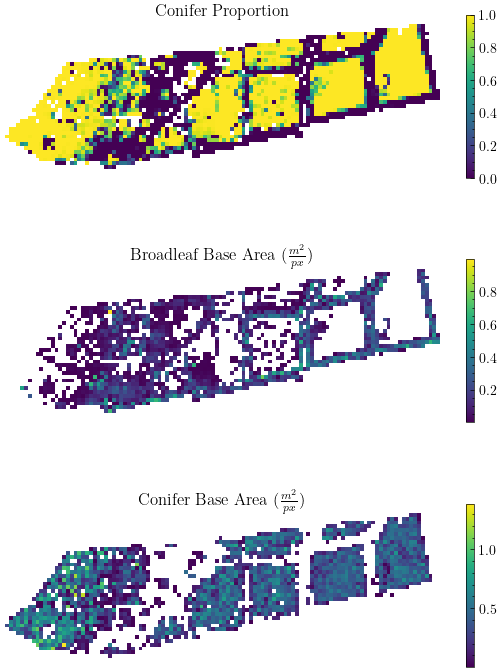

In [5]:
# Plot the two rasters, plot the base area separately per leaf type
import rasterio
import numpy as np

fig, axes = plt.subplots(3, 1, figsize=(7, 9))

with rasterio.open(target_path) as src:
    # Plot the broadleaf content
    target = src.read(1)

    img = axes[0].imshow(target, cmap="viridis", interpolation="nearest")
    axes[0].set_title("Conifer Proportion")
    axes[0].axis("off")

    fig.colorbar(img, shrink=0.8)

with rasterio.open(target_area_path) as src:
    # Plot the broadleaf area
    broadleaf_area = src.read(1)
    broadleaf_area[broadleaf_area == 0] = np.nan

    img = axes[1].imshow(broadleaf_area, cmap="viridis", interpolation="nearest")
    axes[1].set_title(r"Broadleaf Base Area ($\frac{m^2}{px}$)")
    axes[1].axis("off")

    fig.colorbar(img, shrink=0.8)

    # Plot the conifer area
    conifer_area = src.read(2)
    conifer_area[conifer_area == 0] = np.nan

    img = axes[2].imshow(conifer_area, cmap="viridis", interpolation="nearest")
    axes[2].set_title(r"Conifer Base Area ($\frac{m^2}{px}$)")
    axes[2].axis("off")

    fig.colorbar(img, shrink=0.8)

figure_path = "../reports/figures/ground_truth/Conifer Proportion and Base Areas.svg"
plt.savefig(figure_path, dpi=300, transparent=True)

# Sentinel 2 Data

The Sentinel 2 data corresponding to the target label is generated using the Google Earth Engine. The data is filtered by the plot boundaries and a specified time range. The data is then reduced to the temporal resolution of the ground truth data. The data is then exported to a GeoTIFF file.

We prefer using the [Harmonized Sentinel-2 MSI: MultiSpectral Instrument, Level-2A](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED) dataset, as it is atmospherically corrected and harmonized, shifting data in newer scenes to a range comparable to older scenes. However the [Harmonized Sentinel-2 MSI: MultiSpectral Instrument, Level-1C](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_HARMONIZED) dataset is available for all Sentinel 2 imagery, starting at 27th of june 2015 while Level-2A data is only available since 28th of march 2017.

To decide which dataset to use, we compare the two datasets. We use a time range of one year, starting at july 1st 2015 for the Level-1C data. The time range of a year starting at april 1st 2017 is used for the Level-2A data. We then compare the two datasets by cross validating a random forest with default parameters using Scikit-Learn and the root mean squared error.

In [6]:
# Create Level-1C and 2A imagery
from ltm.data import sentinel_composite
from datetime import datetime
from pathlib import Path
from sklearn.metrics import make_scorer, root_mean_squared_error
from ltm.features import load_raster
from sklearn.model_selection import cross_validate

rmse_scorer = make_scorer(root_mean_squared_error)
level_1c_path = "../data/processed/ground_truth/data_1C.tif"
level_2a_path = "../data/processed/ground_truth/data_2A.tif"
target_path = "../data/processed/target.tif"

# Create the 1C composite if it does not exist
if not Path(level_1c_path).exists():
    Path(level_1c_path).parent.mkdir(parents=True, exist_ok=True)
    sentinel_composite(
        target_path_from=target_path,
        data_path_to=level_1c_path,
        time_window=(datetime(2015, 7, 1), datetime(2016, 7, 1)),
        level_2a=False,
    )

# Create the 2A composite if it does not exist
if not Path(level_2a_path).exists():
    Path(level_2a_path).parent.mkdir(parents=True, exist_ok=True)
    sentinel_composite(
        target_path_from=target_path,
        data_path_to=level_2a_path,
        time_window=(datetime(2017, 4, 1), datetime(2018, 4, 1)),
    )

In [7]:
# Compare it to the baseline
from sklearn.ensemble import RandomForestRegressor

# Load data
level_1c_data = load_raster(level_1c_path)
level_2a_data = load_raster(level_2a_path)
target = load_raster(target_path)

# Drop rows with NaN label
level_1c_data = level_1c_data[target.notna()]
level_2a_data = level_2a_data[target.notna()]
target = target[target.notna()]

# Cross validate Random Forest on Level-1C data
rf_regressor = RandomForestRegressor(n_jobs=-1, random_state=42)
level_1c_result = cross_validate(
    rf_regressor, level_1c_data, target, cv=5, scoring=rmse_scorer, n_jobs=-1
)
level_1c_score = level_1c_result["test_score"].mean()

# Cross validate Random Forest on Level-2A data
level_2a_result = cross_validate(
    rf_regressor, level_2a_data, target, cv=5, scoring=rmse_scorer, n_jobs=-1
)
level_2a_score = level_2a_result["test_score"].mean()

# Print scores
print(f"Level-1C RMSE: {level_1c_score}")
print(f"Level-2A RMSE: {level_2a_score}")

Level-1C RMSE: 0.3061696264126286
Level-2A RMSE: 0.3060081806966466


This experiment achieved a marginally lower Root Mean Squared Error (RMSE) when using Level-2A data. As Level-2A data is the preferred product, it will be utilized for all future experiments. However, Level-2A data is only available for more recent Sentinel-2 imagery, as noted above. Consequently, the following experiments will employ a one-year time range starting from April 1st, 2017, to ensure availability of the Level-2A data.